In [1]:
import glob
import numpy as np
import pandas as pd
# suppresses annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import random

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

### Getting the data

In [2]:
fnames = glob.glob("gas_prices_2020-08-01_2021-01-20_5%*")

# concat all data into one dataframe
l = []
for fname in fnames:
    df = pd.read_csv(fname, index_col=None, delimiter='\t')
    l.append(df)

df = pd.concat(l, axis=0, ignore_index=True)

# convert wei to gwei
df['gasPrice'] = df['gasPrice'] / 1_000_000_000

# remove last block num just in case (files are cut off)
df = df[df.blockNum != df.blockNum.max()]

df

,blockNum,txnID,gasPrice
0,10614564,0x5aa8248b7964d5193b1632f221a9eee8b305b7f75419...,97.0
1,10614564,0x00ef094b51f9e8b7d108cd43ea0c40caa7937ca3815d...,97.0
2,10614564,0xc58eeca047c11b8b104e26e66a7e6458dd733e8ea9d3...,97.0
3,10614564,0xef906a00163a108fff92d570111b427f0c13337e1fbc...,97.0
4,10614564,0xbe21511a5a8a384614277ffdaabbc497a7481645561b...,97.0
...,...,...,...
406572,10611164,0xe800ca97acf2877ca91cf20e1d7d62d64f54c99a0835...,65.0
406573,10611164,0xce8db51c6939cc6807d930e54058b80ea1e340d612b9...,65.0
406574,10611164,0xf4e6b9d39084f650c583e64468a57c10f89a2d822a47...,65.0
406575,10611164,0xea198f0621d2e8ec1156cde2f118a0e888ee384bfed6...,65.0


# What does the distribution of gas prices in a block look like?
We normalize gas prices so to pay more attention to shape of distribution, rather than the raw gas price values.

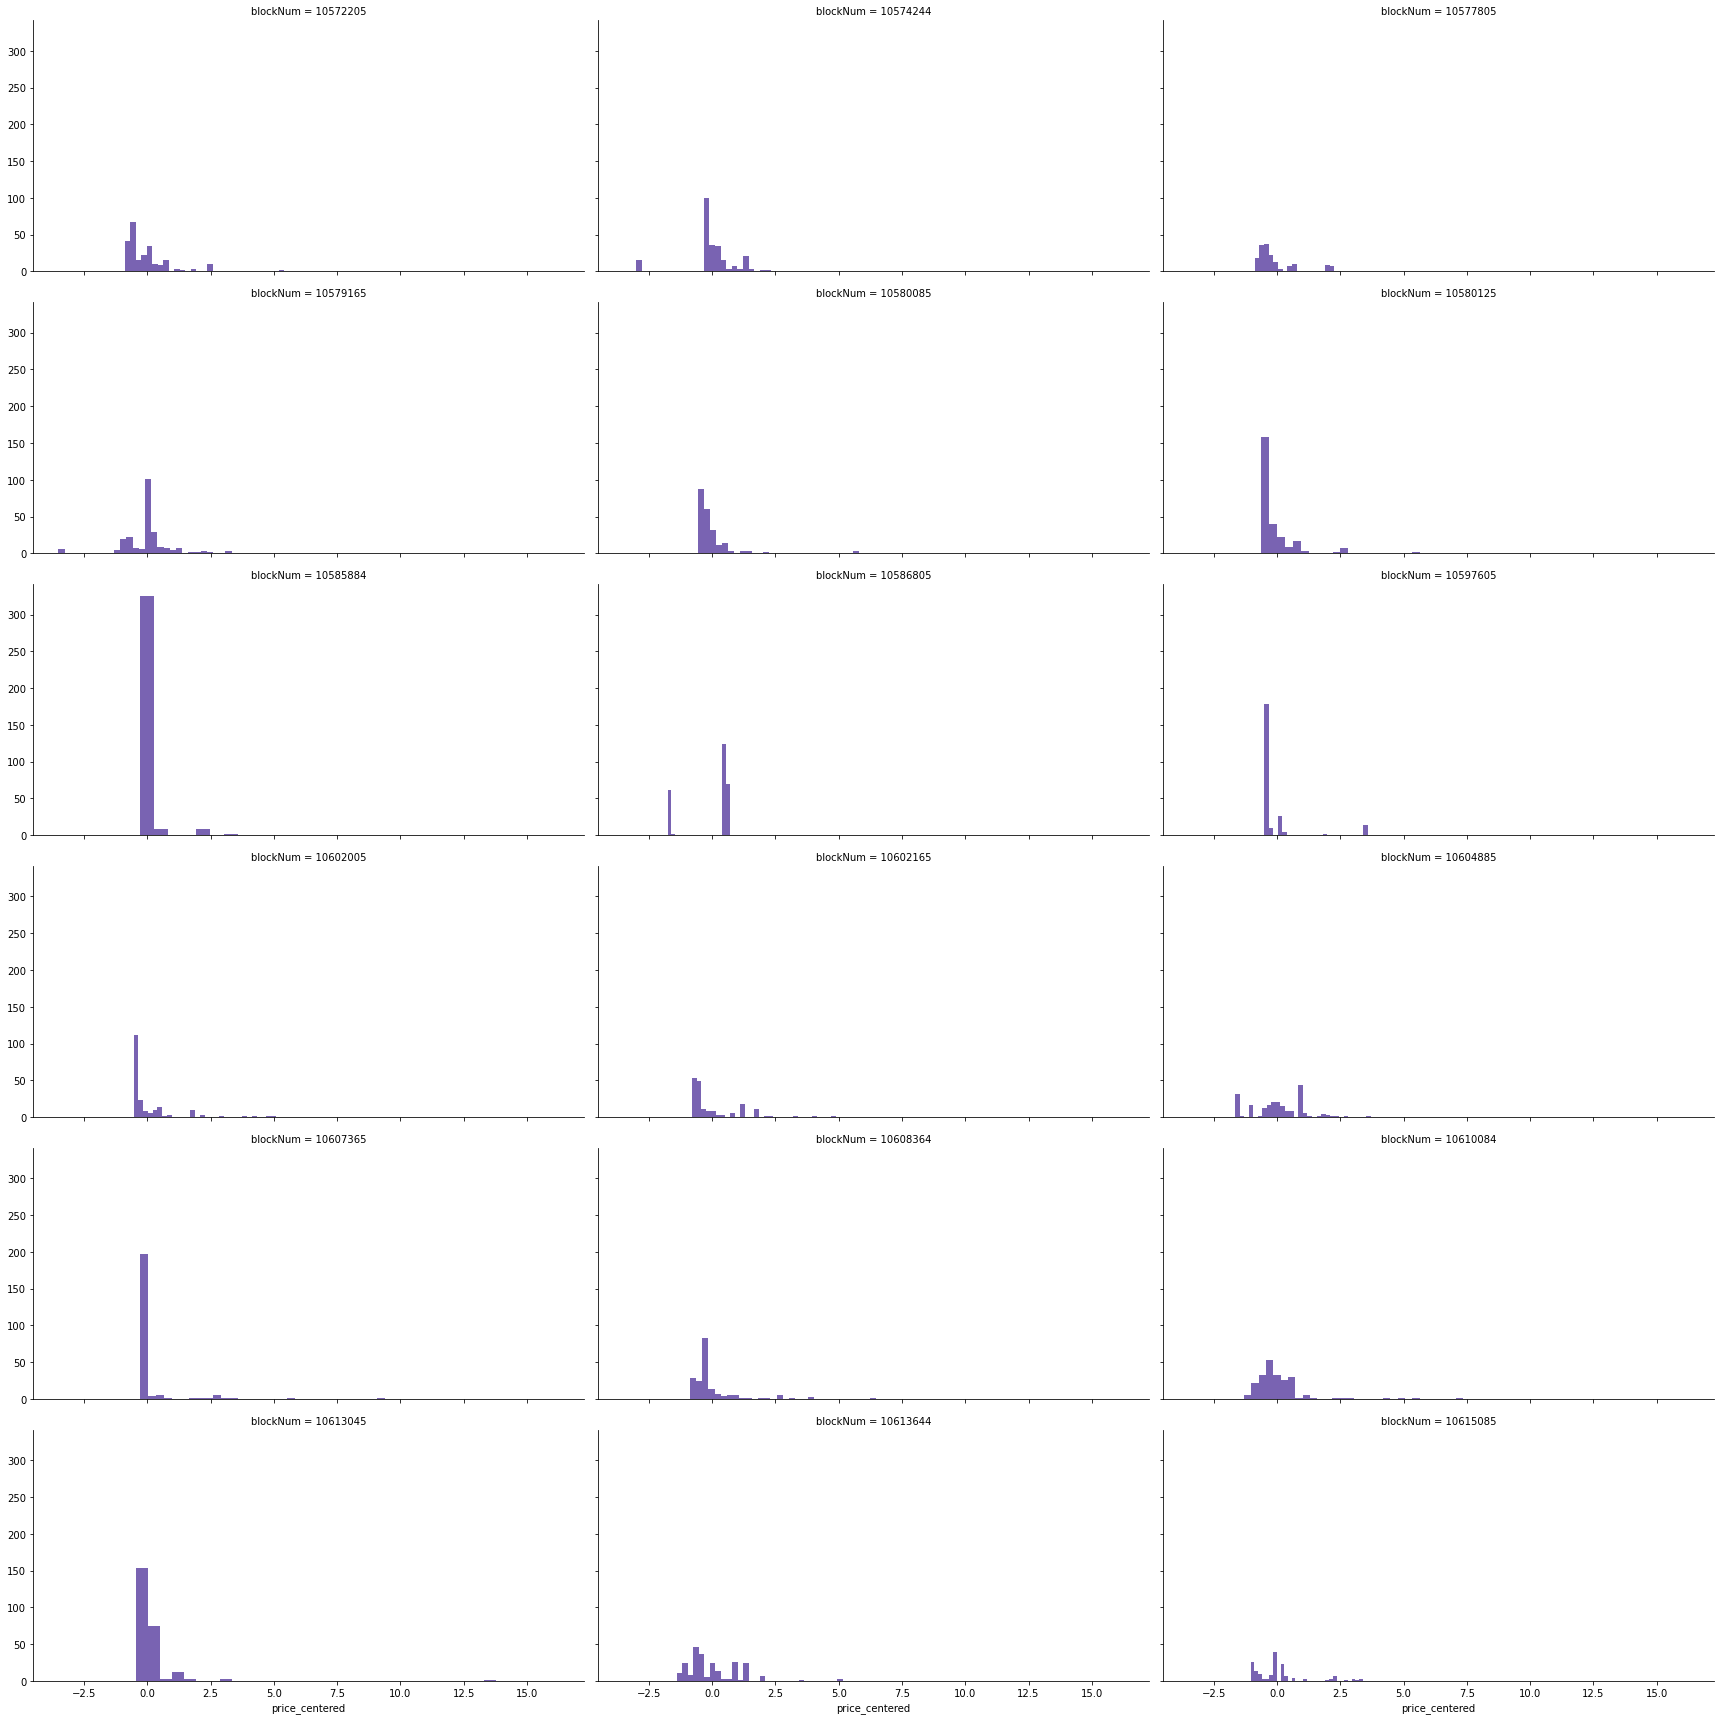

In [3]:
# randomly select blocks from the data
sample_n = 18
block_nums = random.sample(list(set(df['blockNum'])), sample_n)
df_sample = df[df.blockNum.isin(block_nums)]
# normalize
df_sample['price_centered'] = df_sample.groupby('blockNum')['gasPrice'].transform(
    lambda x: (x - x.mean()) / x.std()
) 

g = sns.FacetGrid(df_sample, col="blockNum", col_wrap=3, height=4, aspect=2)
g.map(
    sns.distplot, "price_centered", rug=False,
    hist_kws=dict(alpha=1), **{'bins': 30, 'color': API3_PURPLE},
    kde=False
);

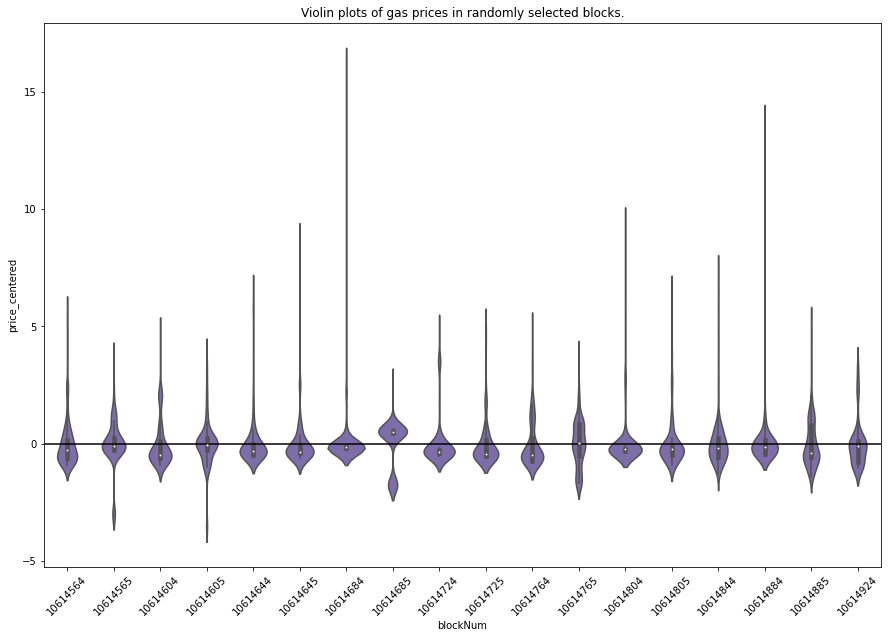

In [4]:
# violin plots to visually detect skewness
_, ax = plt.subplots(1, 1, figsize=(15,10))
g = sns.violinplot(
    ax=ax,
    x="blockNum",
    y="price_centered",
    height=1,
    aspect=1,
    color=API3_PURPLE,
    data=df_sample
)

g.set_title('Violin plots of gas prices in randomly selected blocks.')

g.set_xticklabels(
    labels=df['blockNum'].unique(),
    fontdict={'fontsize': 10},
    rotation=45
);
ax = g.axes
ax.axhline(0, color='black');

## Comments
- There's clearly a strong right skew -- this makes sense: there's probably some frontrunning (or, less extreme, just people needing txns confirmed quickly) in each block which causes the right skew (towards higher gas prices)
- The mode tends to be around the lowest gas price in a block. This is more evident in the first set of plots.
    - This is potentially concerning to our analysis. Consider the mode being $x$ in block $B$, the minimum gas price in a block. I think this would imply that there are probably plenty of txns in the mempool that have that same gas price (consider: what are the chances that all txns in the mempool with gas price $x$ get mined in block $B$).
    - That is, I don't think we can assume having a txn with the minimum gas price mined in a given block implies it would get mined. A safer assumption would probably be having the gas price be *strictly* greater.
- I think there's a lot potentially to look at with the outliers/skew: for one thing, I wonder if the degree of skew is a predictor of increasing gas prices?

# How many of these transactions have a gas price greater than the min of the next block?

In [5]:
# get minimum gas price for each block
df_mins = df.groupby("blockNum", as_index=True)["gasPrice"].min()
df_mins

blockNum
10570484    45.100000
10570485    45.000000
10570524    44.000000
10570525    45.000000
10570564    41.000000
              ...    
10615205    40.000000
10615244    35.600000
10615245    38.000000
10615284    34.270048
10615285    37.000000
Name: gasPrice, Length: 2154, dtype: float64

In [6]:
def f(row):
    if row['blockNum'] + 1 not in df_mins.index:
        return np.nan
    elif row['gasPrice'] > df_mins.loc[row['blockNum'] + 1]:
        return 1
    else:
        return 0
    
df['is_greater_than_min_next_block'] = df.apply(f, axis=1)

In [7]:
df[df['is_greater_than_min_next_block'] == np.nan]

,blockNum,txnID,gasPrice,is_greater_than_min_next_block


In [8]:
res = df.groupby('is_greater_than_min_next_block').count()
res

,blockNum,txnID,gasPrice
is_greater_than_min_next_block,,,
0.0,27972,27972,27972
1.0,165910,165910,165910


In [9]:
# total proportion of all txns
res.loc[1].blockNum / (res.loc[0].blockNum + res.loc[1].blockNum)

0.8557266791141003

## What about distribution per block?
I.e. is there a lot of variability with this proportion block to block?

In [10]:
df_ = df.dropna()
print('total number of blocks:')
print(len(df_.blockNum.unique()))

total number of blocks:
1034


In [11]:
grouped = df_.groupby('blockNum').mean()
grouped

,gasPrice,is_greater_than_min_next_block
blockNum,,
10570484,68.802892,1.000000
10570524,51.215623,0.360731
10570604,55.907080,1.000000
10570644,61.264310,1.000000
10570684,47.645609,1.000000
...,...,...
10615124,56.776308,1.000000
10615164,48.278048,0.976608
10615204,42.919780,0.552239


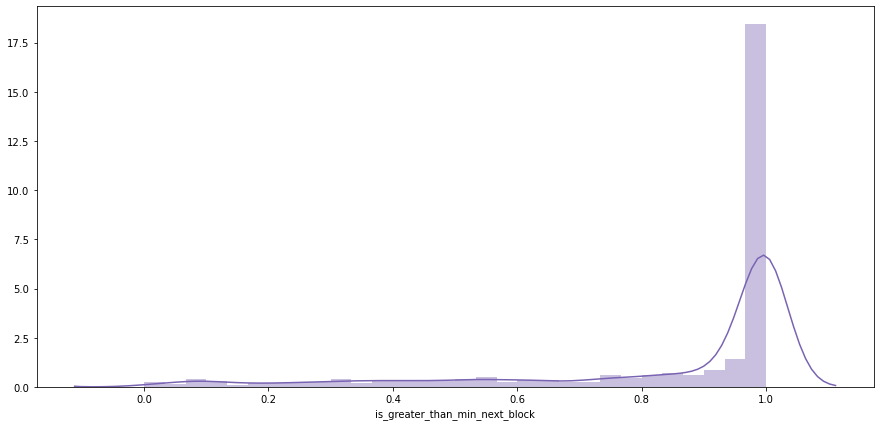

In [12]:
_, ax = plt.subplots(1, 1, figsize=(15,7))
sns.distplot(grouped["is_greater_than_min_next_block"], kde=True, **{'bins': 30, 'color': API3_PURPLE});

### How many blocks have *all* txns satsifying the condition?
where condition == the gas price is *strictly greater* than the min of the next block

In [13]:
(grouped["is_greater_than_min_next_block"] > 0.999).mean()

0.5029013539651838

### How many blocks have *none* of the txns satisifying the condition?

In [14]:
(grouped["is_greater_than_min_next_block"] <= 0.001).mean()

0.0009671179883945841

### How many blocks have *less than half* satisifying the condition?

In [15]:
(grouped["is_greater_than_min_next_block"] < 0.5).mean()

0.13346228239845262

## Comments:
This is kind of what I was expecting / worried about: *most* of the time this works fine (this == picking a random txn from block $x$, taking it's gas price, and having it be greater than the min of the next block). It's outlier conditions that are worrisome; e.g. those ~15% of blocks that have only 50% of txns satisfy the condition. This implies there's some analysis to be done on these outlier / long-tail scenerios.

### Quick test: is condition satisfication correlated to gas price?

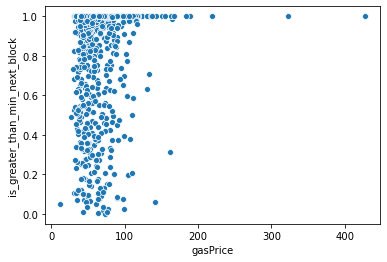

In [16]:
sns.scatterplot(data=grouped, x="gasPrice", y="is_greater_than_min_next_block");

Doesn't look like it. I was thinking maybe condition satisfaction was inversely correlated to gas price, but it doesn't seem to be the case. 

### TODO:
- Further analysis into those outlier cases / long-tail scenerios
- Analyze the assumption that having a gas price greater than the min in a given block is sufficient to get mined